In [ ]:
%load_ext autoreload
%autoreload 2
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datasets
import numpy as np
import os.path
from spacy.lang.en import English
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
import torch
from tqdm import tqdm
import dvu
from typing import List
dvu.set_style()
import pandas as pd
from os.path import join as oj
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import sys
sys.path.append('../experiments')
# import config
pd.set_option('display.max_rows', None)

In [ ]:
import joblib
r = joblib.load('../results/fitted_results_aggregated.pkl')

In [ ]:
r.head()

# Extract the relevant model

In [ ]:
cached_model_fname = oj('..', 'results', 'sst_bert_finetuned_ngrams=2.pkl')
row = pkl.load(open(cached_model_fname, "rb"))

# r = data.load_fitted_results(fname_filters=['bert-base', 'sub=-1'], dset_filters=['sst2'])
# row = r[(r.checkpoint == 'textattack/bert-base-uncased-SST-2') & (r.ngrams == 2)].iloc[0]
# row

# sst (not sst2) dataset

In [ ]:
dset = datasets.load_dataset('sst', 'dictionary')

In [ ]:
dset

In [ ]:
lens = list(map(lambda x: len(x.split()), dset['dictionary']['phrase']))
idxs = np.array(lens) <= 2
idxs_tri = np.array(lens) == 3
label = np.array(dset['dictionary']['label'])[idxs]
label_tri = np.array(dset['dictionary']['label'])[idxs_tri]
phrase = np.array(dset['dictionary']['phrase'])[idxs]
phrase_tri = np.array(dset['dictionary']['phrase'])[idxs_tri]

In [ ]:
def get_scores(phrase):
    tokenizer = AutoTokenizer.from_pretrained(row.checkpoint) # for actually passing things to the model
    model = AutoModel.from_pretrained(row.checkpoint)
    logistic = row.model
    device = 'cuda'
    tokens = tokenizer(phrase.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)
    model = model.to(device)
    with torch.no_grad():
        output = model(**tokens) # has two keys, 'last_hidden_state', 'pooler_output'
    embs = output[row.layer].cpu().detach().numpy()
    # pkl.dump(embs, open('../results/embs_sst_unigram_bigram.pkl', 'wb'))
    scores = embs @ row.model.coef_.T
    return scores

In [ ]:
scores = get_scores(phrase)
# scores_tri = get_scores(phrase_tri)

In [ ]:
# get linear scores
d = joblib.load('../results/bow_sst2.pkl')
mod = d['model']
vec = d['vectorizer']
mat = vec.transform(phrase)
scores_linear = mat @ mod.coef_.T

In [46]:
l = label
scipy.stats.spearmanr(l, scores)

SignificanceResult(statistic=0.6345052362075632, pvalue=0.0)

In [47]:
scipy.stats.spearmanr(l, scores_linear)

SignificanceResult(statistic=0.3910786688893779, pvalue=0.0)

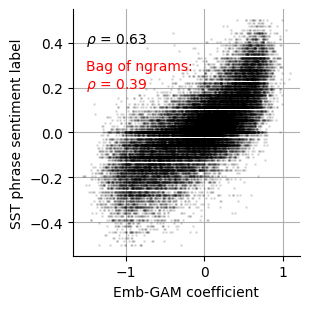

In [58]:
# s = scores_tri
# l = label_tri
s = scores
# s = scores_linear
l = label

plt.figure(figsize=(3.2, 3.2))
# plt.title('B', fontweight='bold', loc='left')
plt.grid()
plt.plot(s, l - 0.5, '.', alpha=0.1, ms=2, color='black')
# df = pd.DataFrame.from_dict({'score': scores.flatten(), 'lab': label.flatten()})
# sns.lmplot(data=df, x='score', y='lab',markers='.')
plt.xlabel('Emb-GAM coefficient') #, fontsize='large')
plt.ylabel('SST phrase sentiment label') #, fontsize='large')
plt.text(-1.5, .4, '$\\rho$ = 0.63')
plt.text(-1.5, .2, 'Bag of ngrams:\n$\\rho$ = 0.39', color='red')
# plt.savefig('sst_embgam.pdf', bbox_inches='tight')
plt.tight_layout()
plt.savefig('sst_embgam.png', dpi=300, bbox_inches='tight')
# plt.savefig('sst_embgam_tri.png', dpi=300, bbox_inches='tight')